In [1]:
import gempyor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
import xarray as xr

## Synthetic dataset from CSP

In [52]:
folder = 'datasets/SMH_R1/'
col2keep = ['incidH_FluA', 'incidH_FluB']

Commands to sync Flu SMH R1
```bash
aws s3 sync s3://idd-inference-runs/USA-20220923T154311/model_output/ . --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T155228/model_output/ SMH_R1_lowVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T160106/model_output/ SMH_R1_highVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T161418/model_output/ SMH_R1_highVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
```


In [53]:
humid = pd.read_csv('datasets/SMH_R1/SMH_R1_lowVac_optImm_2022/r0s_ts_2022-2023.csv', index_col='date', parse_dates=True)

In [54]:
maxfiles = -1
hosp_files = list(Path(str(folder)).rglob('*.parquet'))[:maxfiles]
df = gempyor.read_df(str(hosp_files[0]))

# To be pasted later
indexes = df[['date', 'geoid']]
full_df = df[['date', 'geoid']] # to
geoids = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').columns)
dates = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').index)

In [55]:
geoids

['01000',
 '02000',
 '04000',
 '05000',
 '06000',
 '08000',
 '09000',
 '10000',
 '11000',
 '12000',
 '13000',
 '15000',
 '16000',
 '17000',
 '18000',
 '19000',
 '20000',
 '21000',
 '22000',
 '23000',
 '24000',
 '25000',
 '26000',
 '27000',
 '28000',
 '29000',
 '30000',
 '31000',
 '32000',
 '33000',
 '34000',
 '35000',
 '36000',
 '37000',
 '38000',
 '39000',
 '40000',
 '41000',
 '42000',
 '44000',
 '45000',
 '46000',
 '47000',
 '48000',
 '49000',
 '50000',
 '51000',
 '53000',
 '54000',
 '55000',
 '56000']

In [33]:
df.columns

Index(['date', 'geoid', 'incidI_1dose_FluA_age0to4_R1',
       'incidI_1dose_FluB_age0to4_R1', 'incidI_unvaccinated_FluA_age0to4_R1',
       'incidI_unvaccinated_FluB_age0to4_R1', 'incidI_waned_FluA_age0to4_R1',
       'incidI_waned_FluB_age0to4_R1', 'incidI_1dose_FluA_age18to49_R1',
       'incidI_1dose_FluB_age18to49_R1',
       ...
       'incidD_1dose_FluA_age65to100_R1', 'incidD_1dose_FluB_age65to100_R1',
       'incidD_unvaccinated_FluA_age65to100_R1',
       'incidD_unvaccinated_FluB_age65to100_R1',
       'incidD_waned_FluA_age65to100_R1', 'incidD_waned_FluB_age65to100_R1',
       'incidD_FluA', 'incidD_FluB', 'incidD', 'time'],
      dtype='object', length=135)

In [34]:
incid_xarr = xr.DataArray(-1 * np.ones((len(hosp_files), 
                           len(col2keep),
                           len(full_df.date.unique()),
                           len(full_df.geoid.unique())
                          )), 
                         coords={'sample': np.arange(len(hosp_files)),'feature': col2keep, 'date': dates, 'place': geoids}, 
                         dims=["sample", "feature", "date", "place"])


for i, path_str in enumerate(hosp_files):
    df = gempyor.read_df(str(path_str))
    data = df[col2keep]
    for k, c in enumerate(col2keep):
        incid_xarr.loc[dict(sample=i, feature=c)] = pd.concat([data[c], indexes], axis=1).pivot(values=c, index='date', columns='geoid').to_numpy()
        

    data.columns = [n+f'_{i}' for n in col2keep]   
    full_df = pd.concat([full_df, data], axis=1)
    

print(int((incid_xarr<0).sum()), f' errors on {i} files')

0  errors on 1198 files


In [35]:
humid_st = np.dstack([humid.to_numpy()]*len(hosp_files))
#humid_st = humid_st[:, np.newaxis, :]
print(humid_st.shape)
covar_xarr = xr.DataArray(humid_st, 
                          coords={
                                  #'feature': ['R0Humidity'],
                                  'date': humid.index,
                                  'place': geoids,
                                  'sample': np.arange(len(hosp_files)),}, 
                          dims=[ "date", "place", "sample"]) #"feature",
covar_xarr = covar_xarr.expand_dims({"feature":['R0Humidity']})

(329, 51, 1199)


## makes the dates of r0 and humidity match

In [36]:
print(type(incid_xarr), incid_xarr.date[0], incid_xarr.date[-1] )
print(type(covar_xarr), covar_xarr.date[0], covar_xarr.date[-1])

<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-24 <xarray.DataArray 'date' ()>
array('2023-08-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-08-05
<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-17T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-17 <xarray.DataArray 'date' ()>
array('2023-06-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-06-10


In [37]:
full_xarr = xr.concat([incid_xarr,covar_xarr], dim="feature", join="inner")

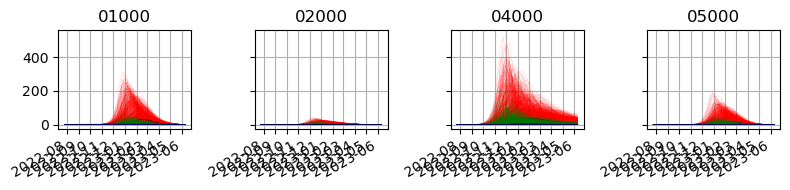

In [38]:
grid = (1,4)
fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
for i, ax in enumerate(axes.flat):
    c = ['red', 'green', 'blue']
    place = full_xarr.get_index('place')[i]
    tp = full_xarr.sel(place=place)
    for k, val in enumerate(full_xarr.feature):
        ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
        ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                c = 'k',#'dark'+c[k], 
                lw = .5, 
                alpha=1)
    ax.grid()
    ax.set_title(place)
fig.autofmt_xdate()
fig.tight_layout()

In [39]:
full_xarr_w = full_xarr.resample(date="W").sum()

In [40]:

full_xarr_w.to_netcdf('datasets/from_csp_weekly_4scn.nc')
full_xarr_w

<xarray.DataArray (sample: 1199, feature: 3, date: 47, place: 51)>
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.06376598e-06, 2.11443244e-07, 3.54247107e-03, ...,
          4.73295388e-04, 9.33385030e-02, 1.93716439e-06],
         [4.29730009e-04, 1.24578936e-05, 5.33482162e-02, ...,
          1.22639995e-02, 6.06410782e-01, 1.61059336e-04],
         ...,
         [1.88776320e+00, 9.62858793e-01, 1.08616342e+01, ...,
          4.05629670e-01, 5.56570183e+00, 5.88609526e-01],
         [9.85928888e-01, 6.96298837e-01, 8.97941558e+00, ...,
          2.60386594e-01, 4.03584103e+00, 5.74680665e-01],
         [5.21960997e-01, 4.56719056e-01, 6.44987651e+00, ...,
          1.61446619e-01, 3.05954377e+00, 4.87531582e-01]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.30674507e-05, 1.33337818e-06, 2.01879211e-01, ...,
          2.10470754e-04, 7.94005659e-05, 1.78481286e-06],
         [4.56224991e-04, 3.81566759e-05, 1.14552382e+00, ...,
          3.95385520e-03, 1.71753344e-03, 6.06723195e-02],
...
         [8.53279152e-01, 4.56214585e-01, 1.36984454e+01, ...,
          6.45575407e-02, 4.06686338e-01, 6.64528323e-02],
         [4.47078263e-01, 2.81140610e-01, 1.15794549e+01, ...,
          3.35818913e-02, 2.08271028e-01, 6.23900490e-02],
         [2.23304383e-01, 1.66465664e-01, 8.52992149e+00, ...,
          1.66030037e-02, 1.02723654e-01, 5.21254748e-02]],

        [[1.29818589e+00, 8.84046265e-01, 8.92386507e-01, ...,
          1.04553332e+00, 9.28917436e-01, 1.20933000e+00],
         [9.09522734e+00, 6.19022749e+00, 6.25138528e+00, ...,
          7.32243452e+00, 6.50398711e+00, 8.52098397e+00],
         [9.15443745e+00, 6.19416716e+00, 6.26310392e+00, ...,
          7.33238501e+00, 6.52042182e+00, 8.66473164e+00],
         ...,
         [1.12684686e+01, 6.92289748e+00, 7.08810851e+00, ...,
          9.06771165e+00, 7.92671422e+00, 1.01696083e+01],
         [1.08090216e+01, 6.66751532e+00, 6.79995176e+00, ...,
          8.48082883e+00, 7.53150989e+00, 9.75008275e+00],
         [8.93078917e+00, 5.54814990e+00, 5.64114587e+00, ...,
          6.87926662e+00, 6.18742508e+00, 8.05758845e+00]]]])
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 ... 1192 1193 1194 1195 1196 1197 1198
  * place    (place) <U5 '01000' '02000' '04000' ... '54000' '55000' '56000'
  * feature  (feature) object 'incidH_FluA' 'incidH_FluB' 'R0Humidity'
  * date     (date) datetime64[ns] 2022-07-24 2022-07-31 ... 2023-06-11

In [41]:
full_xarr_w_padded = full_xarr_w.pad({'date': (0, 17), 'place':(0,13)}, mode='constant', constant_values=0)
print(full_xarr_w_padded.shape)
full_xarr_w_padded.to_netcdf('datasets/from_csp_weekly_pad_4scn.nc')

(1199, 3, 64, 64)


## Real data
Make sure my fork is synced, then
```bash
https://github.com/jcblemai/Flusight-forecast-data.git
```

In [47]:
hosp = pd.read_csv("Flusight-forecast-data/data-truth/truth-Incident Hospitalizations.csv", parse_dates=True, index_col='date')
hosp.columns

Index(['location', 'location_name', 'value'], dtype='object')

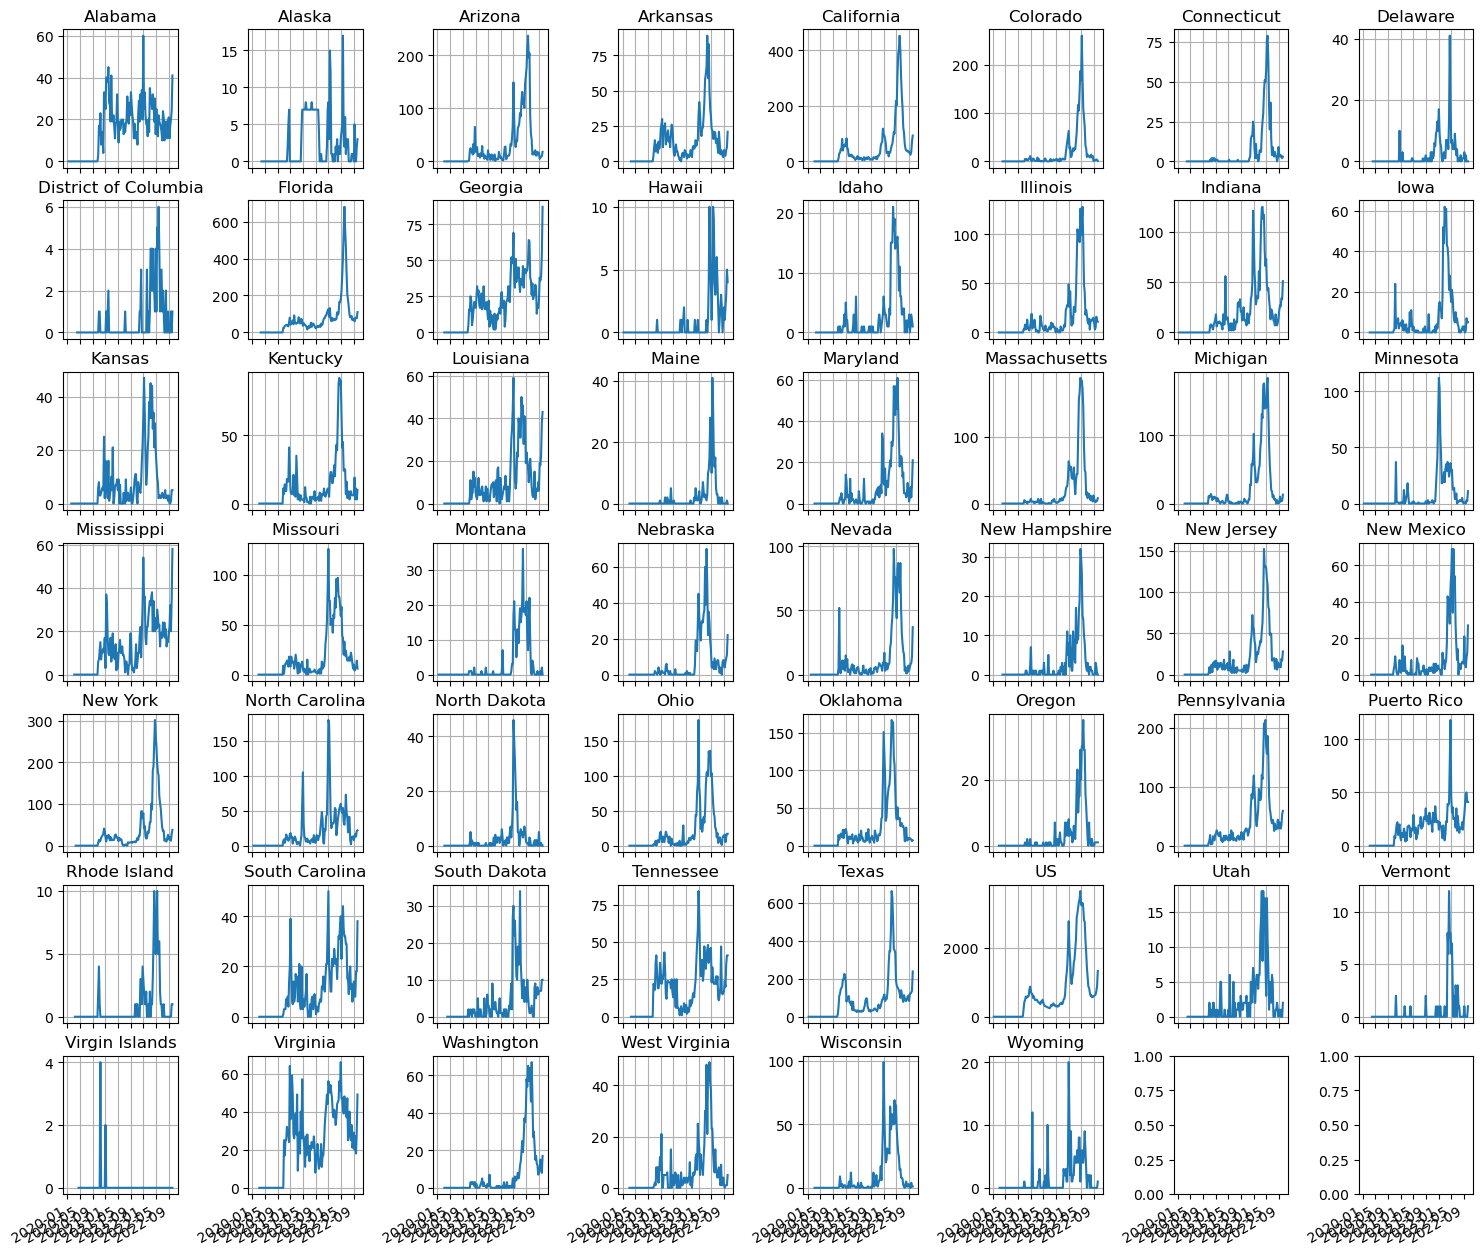

In [49]:
fig, axes = plt.subplots(7, 8, sharex=True, figsize=(15,15))
hosp_piv  = hosp.pivot(columns='location_name', values='value')
for idx, pl in enumerate(np.sort(hosp.location_name.unique())):
    ax = axes.flat[idx]
    ax.plot(hosp_piv[pl])
    ax.set_title(pl)
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

In [50]:
hosp_piv.index

DatetimeIndex(['2020-01-11', '2020-01-18', '2020-01-25', '2020-02-01',
               '2020-02-08', '2020-02-15', '2020-02-22', '2020-02-29',
               '2020-03-07', '2020-03-14',
               ...
               '2022-08-06', '2022-08-13', '2022-08-20', '2022-08-27',
               '2022-09-03', '2022-09-10', '2022-09-17', '2022-09-24',
               '2022-10-01', '2022-10-08'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)

In [43]:
from delphi_epidata import Epidata
# copilot generated from https://github.com/cmu-delphi/delphi-epidata/blob/main/labels/flusurv_locations.txt
flu_surv_location = ['CA', 'CO', 'CT', 'GA', 'IA', 'ID', 'MD', 'MI', 'MN', 'NM', 'NY_albany', 'NY_rochester', 'OH', 'OK', 'OR', 'RI', 'SD', 'TN', 'UT', 'network_all', 'network_eip', 'network_ihsp']
res = Epidata.flusurv(flu_surv_location, [Epidata.range(199401, 202210)])
print(res['result'], res['message'], len(res['epidata']))

2 too many results, data truncated 3650


In [44]:
pd.json_normalize(res['epidata'])

,release_date,location,issue,epiweek,lag,rate_age_0,rate_age_1,rate_age_2,rate_age_3,rate_age_4,rate_overall
0,2017-02-07,CA,201704,200340,695,0.0,0.0,NaN,NaN,NaN,0.000000
1,2017-02-07,CO,201704,200340,695,0.0,0.0,NaN,NaN,NaN,0.000000
2,2017-02-07,CT,201704,200340,695,0.0,0.0,NaN,NaN,NaN,0.000000
3,2017-02-07,GA,201704,200340,695,0.0,0.0,NaN,NaN,NaN,0.000000
4,2017-02-07,MD,201704,200340,695,0.0,0.0,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3645,2017-05-19,NY_albany,201719,201152,280,0.0,0.0,0.000000,0.0,0.000000,0.000000
3646,2017-05-19,NY_rochester,201719,201152,280,0.0,0.0,0.000000,0.0,0.000000,0.000000
3647,2017-05-19,OH,201719,201152,280,0.0,0.0,0.116555,0.0,0.998617,0.161267
3648,2017-05-19,OR,201719,201152,280,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [45]:
res = Epidata.fluview(['nat'], [201440, Epidata.range(201501, 201510)])
print(res['result'], res['message'], len(res['epidata']))
pd.json_normalize(res['epidata'])

1 success 11


,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,num_age_2,num_age_3,num_age_4,num_age_5,wili,ili
0,2017-10-24,nat,201740,201440,157,10150,841540,1937,2958,3994,None,1959,712,527,1.16191,1.20612
1,2017-10-24,nat,201740,201501,143,31483,771835,1958,7160,9589,None,8072,3614,3048,4.21374,4.07898
2,2017-10-24,nat,201740,201502,142,31204,792459,1971,7044,11966,None,6946,2909,2339,4.21022,3.93762
3,2017-10-24,nat,201740,201503,141,33221,800359,1966,7840,13949,None,6451,2951,2030,4.25968,4.15076
4,2017-10-24,nat,201740,201504,140,30621,789407,1955,7118,13159,None,5844,2585,1915,3.97761,3.87899
5,2017-10-24,nat,201740,201505,139,28151,814097,1950,6656,12093,None,5380,2368,1654,3.63443,3.45794
6,2017-10-24,nat,201740,201506,138,25218,823153,1917,6429,10328,None,4884,2072,1505,3.26527,3.06359
7,2017-10-24,nat,201740,201507,137,21109,746836,1907,5537,8164,None,4295,1842,1271,2.93083,2.82646
8,2017-10-24,nat,201740,201508,136,19178,812660,1934,4823,7280,None,4061,1765,1249,2.54474,2.35990
9,2017-10-24,nat,201740,201509,135,18441,789858,1912,4639,7116,None,3914,1696,1076,2.47227,2.33472


### Dengue Trial

In [ ]:
def yw2date(row):
    year = int(row["year"])
    week = int(row["week"])
    date = "{}-{}-1".format(year, week)
    return datetime.strptime(date, "%Y-%W-%w")
df = pd.read_csv('dengue-thailand-province-week.csv')
df['year'] = df['date_sick_year']
df = df.drop('date_sick_year', axis=1)
df['date'] = df.apply(yw2date, axis=1)

## Cannot pivot there are duplicated entries:
df1 = df.set_index(['year', 'week', 'province'])
duplicated = np.where(df1.index.duplicated())
print(len(duplicated[0]), "duplicated index entries...")
print(duplicated[0])
print(df1.iloc[116065])
print(df1.loc[1999, 1, 10])

# pivot_table with aggregrate as mean
df = df.pivot_table(index='date', columns='province', values='cases', aggfunc='mean') # perhaps should be sum
fig, axes = plt.subplots(11, 7, sharex=True, sharey=True, figsize=(10,10))
for i, prov in enumerate(df.columns):
    ax = axes.flat[i]
    ax.plot(df[prov])
    ax.grid()
    ax.set_title(prov)
fig.autofmt_xdate()
fig.tight_layout()